WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


             0
LGBM  0.769074
RF    0.758629
GB    0.768318
0.7714596788454976
[0.3137649  0.09378155 0.54445595 ... 0.77877521 0.61311315 0.33700291]


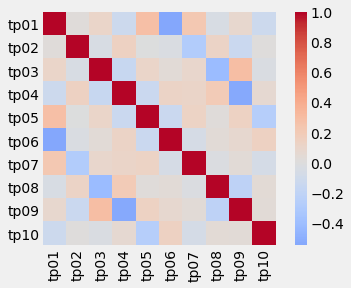

In [1]:
#%% Data load & Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import os
from string import ascii_lowercase
from itertools import combinations
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier
#pip install category_encoders
from category_encoders import TargetEncoder
import warnings
warnings.filterwarnings('ignore')
import matplotlib
plt.style.use('fivethirtyeight')
# pip install impyute
from autoimpute import imputations
from impyute.imputation.cs import mice

train=pd.read_csv('train.csv')
test =pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
train.drop("index",axis=1, inplace = True)
test.drop("index",axis=1, inplace = True)

#%% Preprocessing

### 1. Fill NaN (Mice) ###
# 문자형 변수 제거 / 무응답 na처리
train_imp = train.drop(['gender', 'race', 'religion', 'age_group'],axis=1)  # 문자형 변수 제거
test_imp = test.drop(['gender', 'race', 'religion', 'age_group'],axis=1)  # 문자형 변수 제거
value_mice = ['education','engnat','hand','urban','married']
for i in value_mice :
    train_imp.loc[train_imp[i] == 0, i] = np.nan
    test_imp.loc[test_imp[i] == 0, i] = np.nan

imputed_train=mice(train_imp.values)
imputed_test=mice(test_imp.values)

# 결과값(list)를 dataframe으로 변환
imputed_train = pd.DataFrame(imputed_train)
imputed_train.columns = train_imp.columns
imputed_test = pd.DataFrame(imputed_test)
imputed_test.columns = test_imp.columns

for i in value_mice :
    train[i] = round(imputed_train[i])
    test[i] = round(imputed_test[i])



### 2. LabelEncoding ###
#categorical feature 전처리
label = ['age_group', 'education', 'engnat', 'gender', 'hand', 'married', 'race', 'religion', 'urban']
le = LabelEncoder()
for i in label:
    train[i] = le.fit_transform(train[i]) 
    test[i] = le.fit_transform(test[i]) 



### 3. Make 'voted' dummy value / 1: yes, 0 : no ###
train['voted'] = abs(train['voted']-2)



### 4. Removing outliers ###
# value : familysize
train = train[train.familysize<50]    # 3 rows removed
test = test[test.familysize<50]    # 3 rows removed



### 5. Add Machiavellism Score (Mach_score) ###
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']
''' 히트맵을 통한 음의 상관관계 확인
correlations = train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)
'''
# Reverse known negetive Questions
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    train[flip] = 6 - train[flip]
    test[flip] = 6 - test[flip]
''' 히트맵을 통한 음의 상관관계 확인
correlations = train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)
'''
# Reverse unknown negetive Questions
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    train[flip] = 6 - train[flip]
    test[flip] = 6 - test[flip]
# Finally get a 'Mach_score'
train['Mach_score'] = train[Answers].mean(axis = 1)
test['Mach_score'] = test[Answers].mean(axis = 1)



### 6. 'tp__' score 추가 ###
# tp(01,06) / tp(02,07) / tp(03,08) / tp(04,09) / tp(05,10) 끼리 강한 음의 상관관계 확인
tp = ['tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10']
correlations = train[tp].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)
# 7-tp 함으로서 0을 무응답, 7에 가까울수록 높은 수치로 변환
train[tp] = 7-train[tp]
test[tp] = 7-test[tp]
# 무응답 (0)에 대한 평균 대체
for col in tp:
    train.loc[train[col]==0,col]=sum(train[col])/len(train[col])  
    test.loc[test[col]==0,col]=sum(test[col])/len(train[col])  
# 새로운 score 변수 5개 생성(기존의 음의 상관관계를 가지고 있던 변수끼리의 평균)
train['tp_ex'] = (train['tp01'] + 7 - (train['tp06'])) / 2
test['tp_ex'] = (test['tp01'] + 7 - (test['tp06'])) / 2
train['tp_ag'] = (7 - (train['tp02']) + train['tp07']) / 2
test['tp_ag'] = (7 - (test['tp02']) + test['tp07']) / 2
train['tp_co'] = (train['tp03'] + 7 - (train['tp08'])) / 2
test['tp_co'] = (test['tp03'] + 7 - (test['tp08'])) / 2
train['tp_em'] = (7 - (train['tp04']) + train['tp09']) / 2
test['tp_em'] = (7 - (test['tp04']) + test['tp09']) / 2
train['tp_op'] = (train['tp05'] + 7 - (train['tp10'])) / 2
test['tp_op'] = (test['tp05'] + 7 - (test['tp10'])) / 2


### 7. wr, wf scoring ###
train['wr_many'] = train[['wr_01','wr_02','wr_04','wr_05','wr_07','wr_08','wr_10','wr_12','wr_13']].sum(axis=1)
train['wr_less'] = train[['wr_03','wr_06','wr_09','wr_11']].sum(axis=1)
train['wf_know'] = train[['wf_01','wf_02','wf_03']].sum(axis=1)
test['wr_many'] = test[['wr_01','wr_02','wr_04','wr_05','wr_07','wr_08','wr_10','wr_12','wr_13']].sum(axis=1)
test['wr_less'] = test[['wr_03','wr_06','wr_09','wr_11']].sum(axis=1)
test['wf_know'] = test[['wf_01','wf_02','wf_03']].sum(axis=1)

word = ['wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07', 'wr_08', 
        'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wf_01', 'wf_02', 'wf_03']
train.drop(word, axis=1, inplace=True)
test.drop(word, axis=1, inplace=True)


train = train.drop(['QaA', 'QbA', 'QcA', 'QdA', 'QeA','QfA', 'QgA', 'QhA', 'QiA', 'QjA', 'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA',
           'QaE', 'QbE', 'QcE', 'QdE', 'QeE','QfE', 'QgE', 'QhE', 'QiE', 'QjE', 'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE',
           'tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10'],axis=1)
test = test.drop(['QaA', 'QbA', 'QcA', 'QdA', 'QeA','QfA', 'QgA', 'QhA', 'QiA', 'QjA', 'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 'QpA', 'QqA', 'QrA', 'QsA', 'QtA',
           'QaE', 'QbE', 'QcE', 'QdE', 'QeE','QfE', 'QgE', 'QhE', 'QiE', 'QjE', 'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE',
           'tp01','tp02','tp03','tp04','tp05','tp06','tp07','tp08','tp09','tp10'],axis=1)

#%% Modeling
#%% 1. LGBM, RF, GB Accuracy 동시 확인###
def AUC_func(data):
    # train, test 구분 / random_state : seed number 
    x_train, x_test = train_test_split(data,random_state=2021) 
    y_train = x_train['voted']  # train data의 타겟변수
    y_test = x_test['voted']    # test data의 타겟변수
    x_train.drop('voted',axis=1,inplace=True)
    x_test.drop('voted',axis=1,inplace=True)
    
    # 각 분석 기법 별 classifier 생성 및 진행
    clf_lgbm = LGBMClassifier()
    clf_rf = RandomForestClassifier()
    clf_gb = GradientBoostingClassifier()
    clf_lgbm.fit(x_train, y_train)
    clf_rf.fit(x_train, y_train)
    clf_gb.fit(x_train, y_train)
    # 예측값 생성
    pred_lgbm = clf_lgbm.predict_proba(x_test)
    pred_rf = clf_rf.predict_proba(x_test)
    pred_gb = clf_gb.predict_proba(x_test)
    pred_lgbm = pred_lgbm[:,1]
    pred_rf = pred_rf[:,1]
    pred_gb = pred_gb[:,1]
    # AUC 계산 및 출력
    score_lgbm = roc_auc_score(y_test, pred_lgbm)
    score_rf = roc_auc_score(y_test, pred_rf)
    score_gb = roc_auc_score(y_test, pred_gb)
    
    Score = pd.DataFrame([score_lgbm,score_rf,score_gb])
    Score.index = ['LGBM','RF','GB']
    return(Score)
    print(Score)
auc_3 = AUC_func(train) 
print(auc_3)

#%% 2. 앙상블 코드 ###
x_train, x_test = train_test_split(train,random_state=2021) 
y_train = x_train['voted']  # train set의 타겟변수
y_test = x_test['voted']    # test set의 타겟변수
x_train.drop('voted',axis=1,inplace=True)
x_test.drop('voted',axis=1,inplace=True)

# LGBM, RF, GB 분류기 생성 및 앙상블 진행
clf_rf = RandomForestClassifier(n_estimators=500)     # randomforest 500개의 tree 생성
clf_lgbm = LGBMClassifier()
clf_gb = GradientBoostingClassifier()
soft_vote = VotingClassifier([('r1',clf_rf), ('r2', clf_lgbm), ('r3',clf_gb)], voting='soft')  # 3개의 classfier의 결과의 평균을 채택
soft_vote.fit(x_train, y_train) # train을 가지고 모델링 진행

# 생성된 모델을 가지고 TEST 진행
model = soft_vote
pred_y = model.predict_proba(x_test)
pred_y = pred_y[:,1]

# AUC 계산 및 출력
score_auc = roc_auc_score(y_test, pred_y)
print(score_auc)

# test data를 가지고 예측값 출력
predict = model.predict_proba(test)
predict = predict[:,1]
print(predict)

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from catboost import Pool, CatBoostClassifier
from category_encoders import TargetEncoder

#%% 3. CATBOOST ### 
target = train['voted']
train = train.drop('voted', axis=1)

for i in range(0, 10):
    train.iloc[:,i] = train.iloc[:,i].astype('str')
train['wr_many'] = train['wr_many'].astype('str')
train['wr_less'] = train['wr_less'].astype('str')
train['wf_know'] = train['wf_know'].astype('str')
train['familysize'] = train['familysize'].astype('float')

for i in range(0, 10):
    test.iloc[:,i] = test.iloc[:,i].astype('str')
test['wr_many'] = test['wr_many'].astype('str')
test['wr_less'] = test['wr_less'].astype('str')
test['wf_know'] = test['wf_know'].astype('str')
test['familysize'] = test['familysize'].astype('float') 

categorical_features_indices = np.where(test.dtypes != np.float)[0]
print('Categorial Feature Indices: ', categorical_features_indices)

def run_cv_model(categorical_indices, train, test, target, model_fn, params={}, eval_fn=None, label='model', n_folds=5):
    kf = KFold(n_splits=n_folds)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi = model_fn(categorical_indices, dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results

def runCAT(categorical_indices, train_X, train_y, test_X, test_y, test_X2, params):
    # Pool the data and specify the categorical feature indices
    print('Pool Data')
    _train = Pool(train_X, label=train_y, cat_features = categorical_indices)
    _valid = Pool(test_X, label=test_y, cat_features = categorical_indices)    
    print('Train CAT')
    model = CatBoostClassifier(**params)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=1000,
                          plot=False)
    feature_im = fit_model.feature_importances_
    print('Predict 1/2')
    pred_test_y = fit_model.predict_proba(test_X)[:, 1]
    print('Predict 2/2')
    pred_test_y2 = fit_model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2, feature_im


# Use some baseline parameters
cat_params = {'loss_function': 'CrossEntropy', 
              'eval_metric': "AUC",
              'task_type': "GPU",
              'learning_rate': 0.01,
              'iterations': 10000,
              'random_seed': 42,
              'od_type': "Iter",
#               'bagging_temperature': 0.2,
#               'depth': 10,
              'early_stopping_rounds': 500,
             }

n_folds = 5
results = run_cv_model(categorical_features_indices, train, test, target, runCAT, cat_params, auc, 'cat', n_folds=n_folds)
print(results)

Categorial Feature Indices:  [ 0  1  2  4  5  6  7  8  9 16 17 18]
-------------------------------------------
Started cat fold 1/5
Pool Data
Train CAT
0:	learn: 0.7276821	test: 0.7301508	best: 0.7301508 (0)	total: 235ms	remaining: 39m 10s
1000:	learn: 0.7724397	test: 0.7677913	best: 0.7677947 (999)	total: 1m 49s	remaining: 16m 24s
2000:	learn: 0.7788138	test: 0.7695622	best: 0.7695647 (1999)	total: 3m 35s	remaining: 14m 21s
3000:	learn: 0.7820056	test: 0.7699719	best: 0.7699780 (2985)	total: 5m 11s	remaining: 12m 7s
4000:	learn: 0.7839806	test: 0.7701414	best: 0.7701440 (3965)	total: 6m 45s	remaining: 10m 7s
5000:	learn: 0.7859792	test: 0.7702261	best: 0.7702683 (4764)	total: 8m 17s	remaining: 8m 17s
bestTest = 0.7702682614
bestIteration = 4764
Shrink model to first 4765 iterations.
Predict 1/2
Predict 2/2
cat cv score 1: 0.7702681405306258 

-------------------------------------------
Started cat fold 2/5
Pool Data
Train CAT
0:	learn: 0.7238111	test: 0.7303854	best: 0.7303854 (0)	tot

In [3]:
# Make submission
submission = pd.DataFrame({'target': results['test']})
submission.to_csv('submission.csv', index=False)

In [4]:
# Calculate the average feature importance for each feature
feature_importances = results['fi']
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_folds)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')
feature_importances.sort_values(by='average', ascending=False).head()

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
1,education,23.016511,23.176323,23.154954,21.160363,18.679073,21.837445
0,age_group,20.912221,19.802208,20.225122,22.781710,22.404483,21.225149
8,religion,18.702256,19.104747,19.341763,18.648133,19.172730,18.993925
7,race,8.973157,8.211294,8.512002,9.415362,10.025471,9.027457
16,wr_many,7.868877,7.824446,8.266512,7.417010,8.813940,8.038157


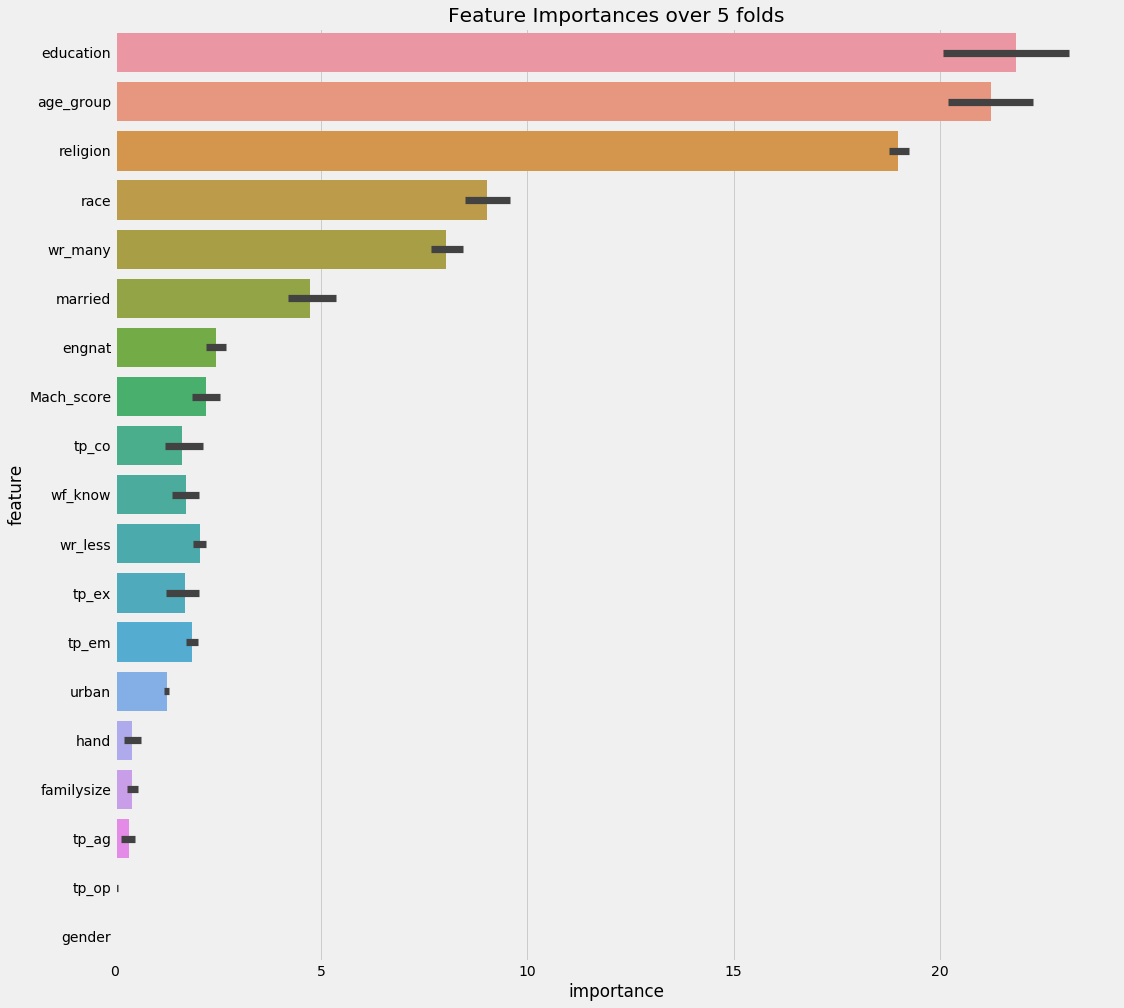

In [5]:
# Plot the feature importances with min/max/average using seaborn
feature_importances_flatten = pd.DataFrame()
for i in range(1, len(feature_importances.columns)-1):
    col = ['feature', feature_importances.columns.values[i]]
    feature_importances_flatten = pd.concat([feature_importances_flatten, feature_importances[col].rename(columns={f'fold_{i}': 'importance'})], axis=0)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances_flatten.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances over {} folds'.format(n_folds))  
plt.savefig("feature_importances.png")
